# Generating Faces with CVAE in PyTorch [TRAIN]

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable

from torchvision import datasets, transforms, models
import torchvision.transforms as transforms
from torch.utils.data import Dataset, random_split, DataLoader
from torchvision.utils import save_image

from torchsummary import summary

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import os
import math
from PIL import Image
from IPython.display import display
import glob

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [3]:
transformObj = transforms.Compose([
    transforms.Resize(64),
    transforms.CenterCrop(64),
    transforms.ToTensor(),
])

In [4]:
dataroot = "./celeba/"

dataset = datasets.ImageFolder(root=dataroot, transform=transformObj)

dataloader = torch.utils.data.DataLoader(dataset, batch_size=16, shuffle=True)

In [5]:
class VAE(nn.Module):
    def __init__(self, latent_size=100):
        super(VAE, self).__init__()
        
        self.latent_size = latent_size
        
        self.l1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=4, stride=2, padding=1)
        self.l1b = nn.BatchNorm2d(32)
        self.l2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=4, stride=2, padding=1)
        self.l2b = nn.BatchNorm2d(64)
        self.l3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=4, stride=2, padding=1)
        self.l3b = nn.BatchNorm2d(128)
        self.l4 = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=4, stride=2, padding=1)
        self.l4b = nn.BatchNorm2d(256)
        
        self.l41 = nn.Linear(256*4*4, self.latent_size)
        self.l42 = nn.Linear(256*4*4, self.latent_size)
        
        self.f = nn.Linear(self.latent_size, 256*4*4)
        
        self.l5 = nn.ConvTranspose2d(in_channels=256, out_channels=128, kernel_size=4, stride=2, padding=1)
        self.l6 = nn.ConvTranspose2d(in_channels=128, out_channels=64, kernel_size=4, stride=2, padding=1)
        self.l7 = nn.ConvTranspose2d(in_channels=64, out_channels=32, kernel_size=4, stride=2, padding=1)
        self.l8 = nn.ConvTranspose2d(in_channels=32, out_channels=3, kernel_size=4, stride=2, padding=1)
        
    def encoder(self, x_in):
        h = F.leaky_relu(self.l1b(self.l1(x_in)))
        h = F.leaky_relu(self.l2b(self.l2(h)))
        h = F.leaky_relu(self.l3b(self.l3(h)))
        h = F.leaky_relu(self.l4b(self.l4(h)))
        
        h = h.view(h.size(0), -1)
        
        return self.l41(h), self.l42(h)
    
    def decoder(self, z):
        z = self.f(z)
        z = z.view(-1, 256, 4, 4)
        
        z = F.leaky_relu(self.l5(z))
        z = F.leaky_relu(self.l6(z))
        z = F.leaky_relu(self.l7(z))
        z = torch.sigmoid(self.l8(z))
        
        return z
    
    def sampling(self, mu, log_var):
        std = torch.exp(0.5*log_var)
        eps = torch.randn_like(std)
        return torch.add(eps.mul(std), mu)
    
    def forward(self, x_in):
        mu, log_var = self.encoder(x_in)
        z = self.sampling(mu, log_var)
        return self.decoder(z), mu, log_var

In [6]:
vae = VAE()
    
vae.to(device)

VAE(
  (l1): Conv2d(3, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (l1b): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (l2): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (l2b): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (l3): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (l3b): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (l4): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (l4b): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (l41): Linear(in_features=4096, out_features=100, bias=True)
  (l42): Linear(in_features=4096, out_features=100, bias=True)
  (f): Linear(in_features=100, out_features=4096, bias=True)
  (l5): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (l6): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2),

In [7]:
summary(vae, (3, 64, 64))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 32, 32]           1,568
       BatchNorm2d-2           [-1, 32, 32, 32]              64
            Conv2d-3           [-1, 64, 16, 16]          32,832
       BatchNorm2d-4           [-1, 64, 16, 16]             128
            Conv2d-5            [-1, 128, 8, 8]         131,200
       BatchNorm2d-6            [-1, 128, 8, 8]             256
            Conv2d-7            [-1, 256, 4, 4]         524,544
       BatchNorm2d-8            [-1, 256, 4, 4]             512
            Linear-9                  [-1, 100]         409,700
           Linear-10                  [-1, 100]         409,700
           Linear-11                 [-1, 4096]         413,696
  ConvTranspose2d-12            [-1, 128, 8, 8]         524,416
  ConvTranspose2d-13           [-1, 64, 16, 16]         131,136
  ConvTranspose2d-14           [-1, 32,

In [8]:
class VGG_model(nn.Module):
    def __init__(self):
        super(VGG_model, self).__init__()
        self.model_layers = models.vgg.vgg19(pretrained=True).features
        self.content_layers = ["31", "33", "35"]
        
        for parameter in self.model_layers.parameters():
            parameter.requires_grad = False
        
    def forward(self, image):
        batch_size = image.size(0)
        output = image
        output_layers = []
        for name, module in self.model_layers.named_children():
            output = module(output)
            if name in self.content_layers:
                output_layers.append(output.view(batch_size, -1))
        return output_layers
    
    def feature_perceptual_loss(self, recon_x, x):
        total_loss = 0
        for x1, x2 in zip(recon_x, x):
            total_loss += F.mse_loss(x1, x2)
        return total_loss

In [9]:
optimizer = optim.Adam(vae.parameters(), lr=0.0005)

def loss_function(recon_x, x, mu, log_var, vgg_model):
    
    BCE = F.binary_cross_entropy(recon_x, x, reduction='sum')
    #MSL = F.mse_loss(recon_x, x)
    KLD = -0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp()) # KL Divergence from MIT 6.S191
    #return (MSL + KLD)
    
    x_f = vgg_model(x)
    recon_x_f = vgg_model(recon_x)
    FPL = vgg_model.feature_perceptual_loss(recon_x_f, x_f)
    
    return (BCE + KLD + FPL)

In [10]:
def train(epoch):
    vae.train()
    
    vgg = VGG_model().to(device)

    train_loss = 0
    for batch_idx, (data, _) in enumerate(dataloader):
        data = data.to(device)
        optimizer.zero_grad()
        
        r_batch, mu, log_var = vae(data)

        loss = loss_function(r_batch, data, mu, log_var, vgg)

        loss.backward()
        train_loss += loss.item()
        optimizer.step()
        if batch_idx%2500==0:
            print("Batch no. finished in Epoch: ", batch_idx)
    print("-------------------------------------------------")
    print('Epoch: {} Train mean loss: {:.8f}'.format(epoch, train_loss / len(dataloader.dataset)))
    print("-------------------------------------------------")
    return train_loss

In [11]:
n_epoches = 8

loss_hist = []

for epoch in range(1, n_epoches+1):
    loss_epoch = train(epoch)
    loss_hist.append(loss_epoch)

Batch no. finished in Epoch:  0
Batch no. finished in Epoch:  2500
Batch no. finished in Epoch:  5000
Batch no. finished in Epoch:  7500
Batch no. finished in Epoch:  10000
Batch no. finished in Epoch:  12500
-------------------------------------------------
Epoch: 1 Train mean loss: 6444.45138089
-------------------------------------------------
Batch no. finished in Epoch:  0
Batch no. finished in Epoch:  2500
Batch no. finished in Epoch:  5000
Batch no. finished in Epoch:  7500
Batch no. finished in Epoch:  10000
Batch no. finished in Epoch:  12500
-------------------------------------------------
Epoch: 2 Train mean loss: 6341.52569205
-------------------------------------------------
Batch no. finished in Epoch:  0
Batch no. finished in Epoch:  2500
Batch no. finished in Epoch:  5000
Batch no. finished in Epoch:  7500
Batch no. finished in Epoch:  10000
Batch no. finished in Epoch:  12500
-------------------------------------------------
Epoch: 3 Train mean loss: 6322.78354269
---

In [15]:
with torch.no_grad():
    counter = 0
    for i in range(100): 
        counter += 1
        z = (torch.rand(100)*2).to(device)
        sample = vae.decoder(z).to(device)
        save_image(sample.view(3, 64, 64), './samplesFACES/sample' + str(counter) + '.png')

In [13]:
torch.save(vae.state_dict(), "./model_weight/wf.pt")

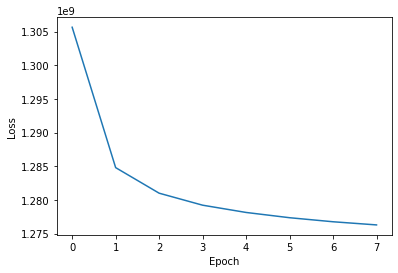

In [14]:
plt.plot(loss_hist)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()